In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import rand
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
plt.rcParams["figure.figsize"] = (5,5)
np.random.seed(179104870) # for reproducibility 

## The Ising Model
The Ising model is an elementary model of magnetism commonly used in physics. It is represented as a lattice (of any shape, for this project I use a square lattice, however I test the results on a triangular lattice at the end) where at each lattice site a magnetic spin state, $\sigma_i$, is either $+1$ or $-1$, describing up and down spin repsectively. Each spin interacts with its nearest neighbor with some interaction quantified in the variable $J$ (it is common to set $J =1$ and I do so in the code). The Ising model Hamiltonian is:
$$H = -J\sum_{\left\langle i, j\right\rangle}\sigma_i\sigma_j$$
where the $\left\langle i, j\right\rangle$ represents a sum of the nearest neighbors.

My goal in this project is to reproduce the results outlined in this paper: https://www.nature.com/articles/nphys4035 by Juan Carrasquilla & Roger G. Melko, So I will be using the 2D Ising model and looking at the phase transition between the ordered (ferromagnetic; spins tend to have a preferred orientation $1$ or $-1$) and disordered (paramagnetic; spins have no preferred orientation) states.

The 2D Ising model undergoes a phase transition at the critical temperature $T_c$. The magnetization of the system is defined as the average over the spins $m = \frac{1}{N}\sum_i^N\sigma_i$ and it is a theoretical device called an order parameter used to distinguish between the two phases. In the ferromagnetic state $m\approx1$ (or $-1$) and in the paramagnetic state $m\approx0$.


In [2]:
'''initialization of the 2D square lattice with dimensions length by length'''
def init_lat(length):
    lat = 2*np.random.randint(2, size=(length, length))-1
    return lat

## The Metropolis–Hastings algorithm
To simulate the Ising model the Monte Carlo method is used as it lends itself nicely to the stochastic behavior of the system. Some commonly used sampling algorithms that are used to simulate the Ising model are the Wolff and Swendsen-Wang cluster algorithms, and the Metropolis-Hastings algorithm. Carrasquilla and Melko don't specify how they prepared their configurations for training so I have chosen the Metropolis-Hastings algorithm as it is simple to implement.

1. Initialize lattice
2. Choose a random lattice site and propose a spin flip
3. Calculate the change in energy $\Delta E = E_{new}-E_{old}$
4. If $\Delta E < 0$, accept the spin flip. Else, accept with probability $e^{-\frac{\Delta E}{k_{B}T}}$.
5. Repeat steps 2-4

After the lattice has been initalized in step 1, it usually needs to be equilibriated with the heat bath, this is done by sweeping the lattice with the algorithm a number of times before taking an actual measurement.

In step 4, the idea is to generate a random number between 0 and 1, and if this number is less than $e^{-\frac{\Delta E}{k_{B}T}}$ you accept.

$k_B$ is the [Boltzman constant](https://en.wikipedia.org/wiki/Boltzmann_constant), I have also set this to $1$

In [3]:
def mon_car_move(lat, temp, length):
'''Monte Carlo move using Metropolis–Hastings algorithm'''
    for i in range(length):
        for j in range(length):
            n = np.random.randint(0, length)
            m = np.random.randint(0, length)
            spin = lat[n, m]
            nL = lat[(n - 1) % length, m]
            nR = lat[(n + 1) % length, m]
            nU = lat[n, (m - 1) % length]
            nD = lat[n, (m + 1) % length]
            near_nbs = nL + nR + nU + nD 
            dE = 2 * spin * near_nbs
            if dE < 0:
                spin *= -1
            elif rand() < np.exp(-dE * (1.0 / temp)):
                spin *= -1
            lat[n, m] = spin
    return lat

In [4]:
def magnetization(lat):
'''Calculates magnetization of lattice'''
    mag = np.sum(lat)
    return mag

In [5]:
L = 30  # linear length of a square lattice
num_sweeps = 10000  # number of monte carlo sweeps of lattice
lattices = [] # lattices for training/testing
lat_labels = [] # tempearture labels of lattices
num_temps = 120 # number of temperatures to sample
num_lats = 2500 # appx number of lattices per temperature to save for training/testing
T_low = 1.0
T_high = 5.3
# random set of temperatures between T_low and T_high
T = T_low + np.random.random(num_temps) * (T_high - T_low)
mag_per_spin = np.zeros(num_temps)

In [6]:
for k in range(num_temps):
    mag_at_temp = 0
    # initialize the lattice
    lat = init_lat(L)
    
    # equilibrate the lattice
    for i in range(num_sweeps):
        mon_car_move(lat, T[k], L)
        
    for i in range(num_sweeps):
        mon_car_move(lat, T[k], L)
        if i%(num_sweeps//num_lats)==0:
            lattices.append(np.reshape(np.copy(lat), L*L))
            lat_labels.append(T[k])
        mag_at_temp += magnetization(lat)

# normalize magnetization
mag_per_spin = np.true_divide(mag_per_spin, num_sweeps*L*L)

Here I have plotted the magnetization as a function of temperature for a $30\times30$ lattice. The orange bar is the critical temperature of the 2D square Ising model, $T_c/J = 2/\ln\left(1+\sqrt2\right)$. As you can see, the simulation did quite well as the magnetization drops to zero after the critical temperature. In general this Monte Carlo method has poor performance around the critical temperature as you can see by the non-zero in that region of the plot.

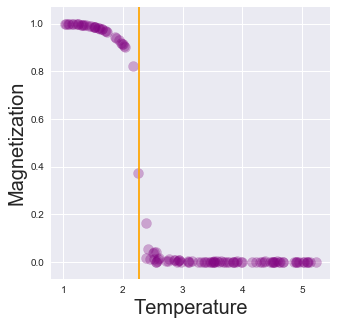

In [7]:
plt.scatter(T, abs(mag_per_spin), color='purple', alpha=0.3, s=100)
plt.xlabel("Temperature", fontsize=20); 
plt.ylabel("Magnetization", fontsize=20);
Tc = 2/(np.log(1+np.sqrt(2)))
plt.axvline(x=Tc, color='orange')

In [8]:
# split data into train and test sets

train_configs = np.array(lattices)
train_labels = np.array(lat_labels)

index = np.random.randint(0, len(train_configs), size = int(0.2*len(train_configs)))

test_configs = train_configs[index]
test_labels = train_labels[index]

In [9]:
train_configs = np.delete(train_configs, index, axis=0)
train_labels = np.delete(train_labels, index,axis=0)

In [10]:
def plot_lat(lat, length):
'''Plots lattice configuration'''
    lat = np.reshape(lat, (length, length))
    x, y, values = zip(*[(i, j, lat[i, j])
                     for i in range(L) for j in range(L)])
    fig = plt.figure()
    plt.scatter(x, y, 30, values, cmap='viridis')
    plt.axis('off')

This is an example of one of the lattice configurations that will be used for training, the purple dots represent a down spin $\left(-1\right)$ and the yellow dots an up spin $\left(+1\right)$

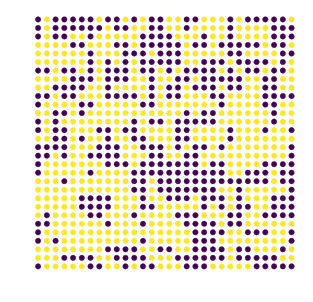

In [11]:
plot_lat(train_configs[5], L)

In [12]:
randindex = np.random.randint(0, len(train_configs), size = 2500)

r_configs = train_configs[randindex]
r_labels = train_labels[randindex]

In [13]:
ppccaa = PCA(n_components=2)
pca_result = ppccaa.fit_transform(r_configs)

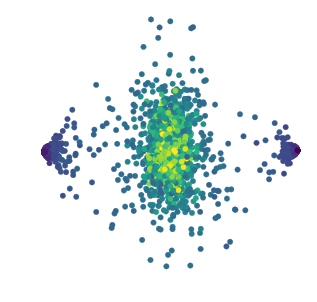

In [14]:
# PCA plot of the training data
plt.scatter(pca_result[:,0], pca_result[:,1], 30, r_labels)
plt.axis('off')
plt.show()

In [15]:
train_tsne = TSNE().fit_transform(r_configs)

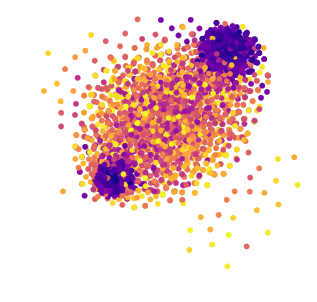

In [16]:
# What's a machine learning project without a t-SNE plot?
plt.scatter(train_tsne[:,0], train_tsne[:,1], 30, r_labels, cmap="plasma")
plt.axis('off')
plt.show()

As I mentioned earlier, the simulation tends to perform quite poorly around the critical temperature, so I remove these configurations from the training set.

In [17]:
T_1 = 2.0
T_2 = 2.5
train_x = []
train_y = []
for i, label in enumerate(train_labels):
    if label < T_1:
        train_x.append(train_configs[i])
        train_y.append((1,0))
    if label > T_2:
        train_x.append(train_configs[i])
        train_y.append((0, 1))
train_x = np.array(train_x)
train_y = np.array(train_y)

With an effort to stay true to the paper, I have tried to construct the exact same network described in the supplementary information addition to the paper. It's got one hidden layer with $100$ neurons; They use $L2$ regularization and Adam optimization. 

In [18]:
network = Sequential()
network.add(
    Dense(100,
        input_dim=L * L,
        kernel_initializer='normal',
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.01)))
network.add(Dense(2, kernel_initializer='random_normal', activation='softmax'))

network.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', metrics=['accuracy'])
batch_si = 32
num_epochs = 50

In [19]:
def plot_hidden_layer(data):
    '''Plots hidden layer of network'''
    layer_1 = network.get_layer(index=0)
    W, b = layer_1.get_weights()
    y = np.dot(W.T, data.T)
    x = np.mean(data, axis=1)
    cmap = plt.get_cmap('prism')
    plt.xlabel('Input Vector')
    plt.ylabel('100 Unit Hidden Layer')
    for i in range(np.shape(b)[0]):
        plt.plot(x, y[i]+b[i], '.', color=cmap(i))

Here I have plotted the output of the hidden layer pre-training

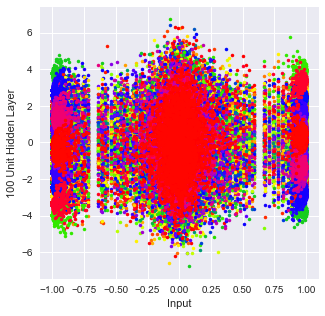

In [20]:
plot_hidden_layer(r_configs)

In [21]:
network.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_si,  verbose=0)

Here I have plotted the output of the hidden layer post-training, this may look like just as much of mess as the pre-training plot, but it does show that the neurons have learned some linear relationship.

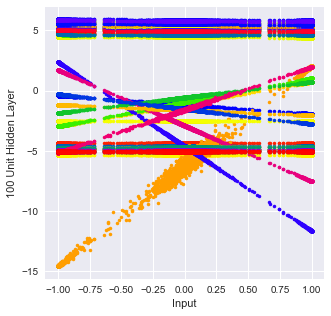

In [22]:
plot_hidden_layer(r_configs)

In [23]:
prediction = network.predict(test_configs)

In [24]:
def plot_pred_data(output_layer, labels, triangle=False):
    '''Plots output of network'''
    tmpr = np.sort(np.unique(labels))
    num_tmpr = len(tmpr)
    num_samples_at_tmpr = np.zeros(num_tmpr)
    
    ferro_state = np.zeros(num_tmpr)
    para_state = np.zeros(num_tmpr)
    
    for i, T in enumerate(labels):
        iT = np.where(tmpr == T)[0]
        ferro_state[iT]+=output_layer[i:i+1, 0][0]
        para_state[iT]+=output_layer[i:i+1, 1][0]
        num_samples_at_tmpr[iT]+=1.0
    ferro_state = np.true_divide(ferro_state, num_samples_at_tmpr)
    para_state = np.true_divide(para_state, num_samples_at_tmpr)
    
    plt.xlabel('Temperature')
    plt.ylabel('Output Layer')
    if triangle==False:
        plt.plot(tmpr, ferro_state, linestyle='-', marker='o', label='ferro', alpha=0.8)
        plt.plot(tmpr, para_state, linestyle='-', marker='o', label='para')
        plt.xlim(1.0, 3.5)
        Tc = 2/(np.log(1+np.sqrt(2)))
    elif triangle==True:
        Tc = 4/(np.log(3))
        plt.xlim(np.amin(tmpr), np.amax(tmpr))
        plt.plot(tmpr, ferro_state, linestyle='-', marker='o', label='ferro')
        plt.plot(tmpr, para_state, linestyle='-', marker='o', label='para')
    plt.axvline(x=Tc, color='orange', label='$T_c$')    
    plt.legend()

Here I've plotted the the output of the network and the magnetization calculated during the simulation against the temperature. It's clear that the network was able to successfully learn the magnetization order parameter as both the disordered and ordered states undergo phase transitions around the critical temperature (in orange).

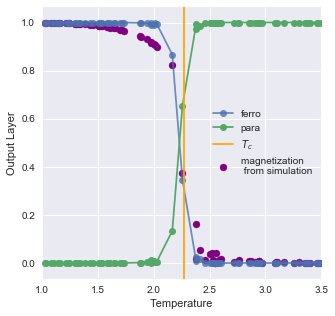

In [25]:
plot_pred_data(prediction, test_labels)
plt.scatter(T, abs(mag_per_spin), color='purple', label='magnetization \n from simulation')
plt.legend()

In [26]:
# testing network against Carrasquilla and Melko's triangle lattice data
# data available here: https://github.com/carrasqu/data_nature_phy_paper
triangle_x = np.array(np.loadtxt("to_upload/L_30/TRIANGXtest.txt"))
triangle_label = np.array(np.loadtxt("to_upload/L_30/TRIANGYtest.txt"))
print("loaded triangle data")

loaded triangle data


In [27]:
triangle_temps = [
    2.0000000000000000, 2.0820478453253499, 2.1640956906506998,
    2.2461435359760498, 2.3281913813013997, 2.4102392266267496,
    2.4922870719520995, 2.5743349172774495, 2.6563827626027994,
    2.7384306079281493, 2.8204784532534992, 2.9025262985788491,
    2.9845741439041991, 3.0666219892295490, 3.1486698345548989,
    3.2307176798802488, 3.3127655252055987, 3.3948133705309487,
    3.4768612158562986, 3.5589090611816485, 3.6409569065069984,
    3.7230047518323484, 3.8050525971576983, 3.8871004424830482,
    3.9691482878083981, 4.0511961331337485, 4.1332439784590989,
    4.2152918237844492, 4.2973396691097996, 4.3793875144351500,
    4.4614353597605003, 4.5434832050858507, 4.6255310504112011,
    4.7075788957365514, 4.7896267410619018, 4.8716745863872521,
    4.9537224317126025, 5.0357702770379529, 5.1178181223633032,
    5.1998659676886536, 5.2819138130140004
]

In [28]:
# I am reformatting their data to plot it
for kk in range(len(triangle_label)):
        triangle_label[kk]=triangle_temps[kk//250]

In [29]:
tri_prediction = network.predict(triangle_x)

The network was trained on square lattice configurations, but I have tested the network on triangular configurations. The results do not look as nice as Carrasquilla and Melko's but we do see evidence that the network is understanding some physics here. The output before the critical temperature is all over the place, but after the critical temperature it seems to be behaving how one would expect; the ferromagnetic state is dropping to zero and the paramagnetic state is ordering itself to one, i.e., there is evidence of a phase transition where one would expect to see one!

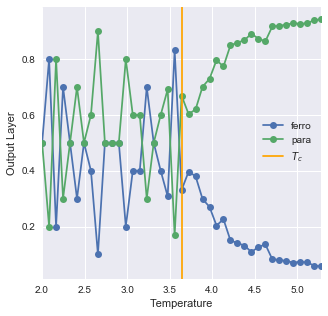

In [30]:
plot_pred_data(tri_prediction, triangle_label, triangle=True)